In [1]:
import pandas as pd
import numpy as np
import pandasql as ps
import time 
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
import pickle
from sklearn.ensemble import GradientBoostingClassifier
warnings.filterwarnings("ignore")

### Extract MBC1 Data
Key  
Time variable  
prefix BL = Baseline  
prefix Rx1 = Intervention week 1  
prefix Rx23 = Intervention weeks 2+3  
prefix FU1 = Followup period 1  
prefix FU2 = Followup period 2  
prefix Fux = Followup period x  
numeral following above prefixes and underscore character designates the sequential day of recording for the indicated time period  
e.g. FU3_03 indicates third day of recording for follow-up period 3

In [2]:
df_all = pd.read_csv('Raw Data/MBC1 Daily Outcome.csv')
df_pa = df_all[['ID', 'Time', 'Condition', 'PA']]
df_sed = df_all[['ID', 'Time', 'Condition','TargetedSed']]
df_fv = df_all[['ID', 'Time', 'Condition','FV']]
df_fat = df_all[['ID', 'Time', 'Condition','SatFat']]

def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True

df_pa_valid = df_pa[df_pa.PA.apply(lambda x: x.isnumeric())]
df_sed_valid = df_sed[df_sed.TargetedSed.apply(lambda x: x.isnumeric())]
df_fv_valid = df_fv[df_fv.FV.apply(lambda x: x.isnumeric())]
df_fat_valid = df_fat[df_fat['SatFat'].apply(lambda x: is_float(x))]

### Extract by timepoint

In [3]:
# BL = Baseline
def baseline(df, col_name):
    df_base = df.loc[df['Time'].str.startswith('BL', na=False)]
    # convert PA minutes to numeric
    df_base[col_name] = df_base[col_name].apply(pd.to_numeric)

    Ids = list(set(df_base['ID']))
    std = list(df_base.groupby('ID').agg('std')[col_name])
    mean = list(df_base.groupby('ID').agg('mean')[col_name])
    df_base_avg = pd.DataFrame({'ID': Ids, str(col_name +'_baseline'):mean, str(col_name +'_baseline_scale'):std})

    #location + scale
    df_base_location = df_base_avg[['ID',str(col_name +'_baseline')]]
    df_base_scale = df_base_avg[['ID',str(col_name +'_baseline_scale')]]
    return df_base_location, df_base_scale

# Rx1 = Intervention week 1
def rx1(df, col_name):
    df_Rx1 = df.loc[df['Time'].str.startswith('Rx1', na=False)]
    # convert PA minutes to numeric
    df_Rx1[col_name] = df_Rx1[col_name].apply(pd.to_numeric)
    Ids = list(set(df_Rx1['ID']))
    std = list(df_Rx1.groupby('ID').agg('std')[col_name])
    mean = list(df_Rx1.groupby('ID').agg('mean')[col_name])
    df_Rx1_avg = pd.DataFrame({'ID': Ids, str(col_name +'_Rx1'):mean, str(col_name +'_Rx1_scale'):std})

    #location + scale
    df_Rx1_location = df_Rx1_avg[['ID',str(col_name +'_Rx1')]]
    df_Rx1_scale = df_Rx1_avg[['ID',str(col_name +'_Rx1_scale')]]
    return df_Rx1_location, df_Rx1_scale

def rx23(df, col_name):
    # Rx23 = Intervention weeks 2+3
    df_Rx23 = df.loc[df['Time'].str.startswith('Rx23', na=False)]
    # convert PA minutes to numeric
    df_Rx23[col_name] = df_Rx23[col_name].apply(pd.to_numeric)

    Ids = list(set(df_Rx23['ID']))
    std = list(df_Rx23.groupby('ID').agg('std')[col_name])
    mean = list(df_Rx23.groupby('ID').agg('mean')[col_name])
    df_Rx23_avg = pd.DataFrame({'ID': Ids, str(col_name +'_Rx23'):mean, str(col_name +'_Rx23_scale'):std})

    #location + scale
    df_Rx23_location = df_Rx23_avg[['ID',str(col_name +'_Rx23')]]
    df_Rx23_scale = df_Rx23_avg[['ID',str(col_name +'_Rx23_scale')]]
    return df_Rx23_location, df_Rx23_scale

# prefix FU1 = Followup period 1
# prefix FU2 = Followup period 2
# prefix Fux = Followup period x
def fu(df, col_name):
    df_FU = df.loc[df['Time'].str.startswith('FU', na=False)]

    #get only the FU week but not day
    df_FU['Time'] = df_FU['Time'].astype('string').str[:3]

    # convert PA minutes to numeric
    df_FU[col_name] = df_FU[col_name].apply(pd.to_numeric)

    df_std = df_FU.groupby(['ID', 'Time']).agg('std')
    df_mean = df_FU.groupby(['ID', 'Time']).agg('mean')

    df_std.to_csv('test1.csv')
    df_mean.to_csv('test2.csv')

    df_std = pd.read_csv('test1.csv')
    df_mean = pd.read_csv('test2.csv')
    
    #rename
    df_std.columns = ['ID', 'Time', 'Condition', str(col_name +'_FU_scale')]
    df_mean.columns = ['ID', 'Time', 'Condition', str(col_name +'_FU')]
    df_FU_avg = pd.merge(df_std, df_mean, how='outer', on=['ID','Time'])
    df_FU_avg = df_FU_avg.drop(['Condition_x', 'Condition_y'], axis=1)
    
    ids = list(df_FU_avg['ID'].unique())
    fu_all = ['FU1','FU2','FU3','FU4','FU5','FU6','FU7','FU8']
    fu_list = []
    for each in ids:
        templist = []
        for fu in fu_all:
            if (df_FU_avg.loc[(df_FU_avg['ID'] == each) & (df_FU_avg['Time'] == fu)].shape[0] == 0):
                templist.append(0) #missing values
            else:
                templist.append(list(df_FU_avg.loc[(df_FU_avg['ID'] == each) & (df_FU_avg['Time'] == fu)][str(col_name +'_FU')])[0])
        fu_list.append(templist)

    df_fu_location = pd.DataFrame(fu_list, columns =fu_all, dtype = float) 
    df_fu_location['ID'] = ids
    return df_fu_location

def mergeall(df, col_name):
    df_base_location = baseline(df, col_name)[0]
    df_Rx1_location = rx1(df, col_name)[0]
    df_Rx23_location = rx23(df, col_name)[0]
    df_fu_location = fu(df, col_name)
    
    # merge all timepoints (full)
    df_1 = pd.merge(df_base_location,df_Rx1_location,on='ID',how='outer')
    df_2 = pd.merge(df_1,df_Rx23_location,on='ID',how='outer')
    df_location = pd.merge(df_2,df_fu_location,on='ID',how='outer')
    df_location = df_location.fillna(0)
    return df_location

In [4]:
df_pa_location = mergeall(df_pa_valid, 'PA')
df_sed_location = mergeall(df_sed_valid, 'TargetedSed')
df_fv_location = mergeall(df_fv_valid, 'FV')
df_fat_location = mergeall(df_fat_valid, 'SatFat')

In [5]:
df_pa_location

,ID,PA_baseline,PA_Rx1,PA_Rx23,FU1,FU2,FU3,FU4,FU5,FU6,FU7,FU8
0,6,112.857143,386.428571,441.923077,454.285714,450.000000,390.000000,90.000000,305.000000,295.000000,380.000000,440.000000
1,7,83.714286,103.333333,115.000000,77.428571,36.666667,36.666667,36.666667,80.500000,60.000000,95.333333,83.333333
2,12,94.642857,147.857143,127.500000,0.000000,35.000000,150.000000,205.000000,310.000000,105.000000,120.000000,105.000000
3,14,12.857143,45.000000,105.357143,231.428571,120.000000,225.000000,115.000000,175.000000,70.000000,30.000000,75.000000
4,15,71.785714,82.142857,103.571429,21.428571,60.000000,18.333333,81.666667,68.333333,46.666667,45.000000,40.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
197,72,0.000000,0.000000,1.764706,51.428571,0.000000,0.000000,0.000000,20.000000,20.000000,0.000000,95.000000
198,8,0.000000,0.000000,0.000000,68.571429,71.666667,143.333333,48.333333,25.000000,48.333333,98.333333,35.000000
199,24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200,35,0.000000,0.000000,0.000000,30.000000,125.000000,20.000000,10.000000,79.666667,0.000000,0.000000,0.000000


## Step 1 Ground Truth Generation

### Definition 1 (10% difference)

In [6]:
# preprocessing for definition 1 (get intervention/follow-up)
def MBC1_clean(df, col_name):  
    df['intervention'] = (df[str(col_name +'_Rx1')] + df[str(col_name +'_Rx23')])/2
    df['follow_up'] = (df['FU6'] + df['FU7'] + df['FU8'])/3
    
    df_temp1 = df.drop(df[df['intervention'] == 0].index)
    df_temp2 = df_temp1.drop(df_temp1[df_temp1['follow_up'] == 0].index)
    
    return df_temp2

df_pa_location = MBC1_clean(df_pa_location, 'PA')
df_sed_location = MBC1_clean(df_sed_location, 'TargetedSed')
df_fv_location = MBC1_clean(df_fv_location, 'FV')
df_fat_location = MBC1_clean(df_fat_location, 'SatFat')

def tenPercent(row):
    if (row['follow_up'] >= (row['intervention']*0.9)):
        val = 'Maintainer'
    else:
        val = 'Non-Maintainer'
    return val

df_pa_location['Label'] = df_pa_location.apply(tenPercent, axis=1)
df_sed_location['Label'] = df_sed_location.apply(tenPercent, axis=1)
df_fv_location['Label'] = df_fv_location.apply(tenPercent, axis=1)
df_fat_location['Label'] = df_fat_location.apply(tenPercent, axis=1)


Maintainers = [sum(list(df_pa_location['Label'] == 'Maintainer')), sum(list(df_sed_location['Label'] == 'Maintainer')), sum(list(df_fv_location['Label'] == 'Maintainer')), sum(list(df_fat_location['Label'] == 'Maintainer'))]
Non_Maintainers = [sum(list(df_pa_location['Label'] == 'Non-Maintainer')), sum(list(df_sed_location['Label'] == 'Non-Maintainer')), sum(list(df_fv_location['Label'] == 'Non-Maintainer')), sum(list(df_fat_location['Label'] == 'Non-Maintainer'))]
Features = ['MVPA', 'SED', 'FV', 'FAT']
pd.DataFrame({'Outcome': Features, 'Maintainers': Maintainers, 'Non-maintainers':Non_Maintainers})

,Outcome,Maintainers,Non-maintainers
0,MVPA,69,97
1,SED,115,56
2,FV,47,119
3,FAT,116,58


### Definition 2 (Meet Goal: 150 MVPA)

In [ ]:
def meetGoal(row):
    if (row['follow_up'] >= 60):
        val = 'Maintainer'
    else:
        val = 'Non-Maintainer'
    return val

df_temp2['Label'] = df_temp2.apply(meetGoal, axis=1)
print('Maintainers:', sum(list(df_temp2['Label'] == 'Maintainer')))
print('Non-Maintainers:', sum(list(df_temp2['Label'] == 'Non-Maintainer')))

### Definition 3 (Slope: zero or positive)

In [64]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def getSlope(df_weekly):
    slope = []
    ids = []
    id_list = list(df_weekly['ID'])
    # set up break point at week 13
    for user_id in id_list:
        user1 = df_weekly[df_weekly['ID'] == user_id]
        follow_up_y = user1.values[0][4:12].reshape(-1,1)
        follow_up_x = np.array(range(1,9)).reshape(-1,1)

        ids.append(user_id)

        # build linear regression models
        regressor = LinearRegression()  
        regressor.fit(follow_up_x, follow_up_y) #training the algorithm
        y_pred = regressor.predict(follow_up_x)

        #To retrieve the intercept:
        #slope1.append(regressor1.coef_[0][0])
        slope.append(regressor.coef_[0][0])
    return slope

slope = getSlope(df_pa_location)
df_pa_location['slope'] = slope
slope = getSlope(df_sed_location)
df_sed_location['slope'] = slope
slope = getSlope(df_fv_location)
df_fv_location['slope'] = slope
slope = getSlope( df_fat_location)
df_fat_location['slope'] = slope

def slopePos(row):
    if (row['slope'] >= 0):
        val = 'Maintainer'
    else:
        val = 'Non-Maintainer'
    return val

df_pa_location['Label'] = df_pa_location.apply(slopePos, axis=1)
df_sed_location['Label'] = df_sed_location.apply(slopePos, axis=1)
df_fv_location['Label'] = df_fv_location.apply(slopePos, axis=1)
df_fat_location['Label'] = df_fat_location.apply(slopePos, axis=1)

Maintainers = [sum(list(df_pa_location['Label'] == 'Maintainer')), sum(list(df_sed_location['Label'] == 'Maintainer')), sum(list(df_fv_location['Label'] == 'Maintainer')), sum(list(df_fat_location['Label'] == 'Maintainer'))]
Non_Maintainers = [sum(list(df_pa_location['Label'] == 'Non-Maintainer')), sum(list(df_sed_location['Label'] == 'Non-Maintainer')), sum(list(df_fv_location['Label'] == 'Non-Maintainer')), sum(list(df_fat_location['Label'] == 'Non-Maintainer'))]
Features = ['MVPA', 'SED', 'FV', 'FAT']
pd.DataFrame({'Outcome': Features, 'Maintainers': Maintainers, 'Non-maintainers':Non_Maintainers})

,Outcome,Maintainers,Non-maintainers
0,MVPA,83,119
1,SED,87,115
2,FV,68,134
3,FAT,84,118


## Step 2 (Merge with MLS estimates)

In [8]:
df_mls1 = pd.read_csv('PhysActivity/paaplus_MLS_ebvar.dat', sep='\s\s+', engine='python', names=["ID", "int", "slope", "scale", "1","2","3","4","5","6"])
df_mls2 = pd.read_csv('PhysActivity/paaplus_LMS11_ebvar.dat', sep='\s\s+', engine='python', names=["ID", "int_loc", "int_Scale", "Slope_ scale", "1","2","3","4","5","6"])
df_mls1 = df_mls1[["ID", "slope", "scale"]]
df_mls2 = df_mls2[["ID", "int_loc", "Slope_ scale"]]
df_mls1.columns = ["ID", "Location_slope", "Scale_intercept"]
df_mls2.columns = ["ID", "Location_intercept", "Scale_slope"]
result_pa = pd.merge(df_mls1, df_mls2, on='ID')
result_pa.head(5)


df_mls1 = pd.read_csv('SedentaryMinutes/Sedent_MLS_ebvar.dat', sep='\s\s+', engine='python', names=["ID", "int", "slope", "scale", "1","2","3","4","5","6"])
df_mls2 = pd.read_csv('SedentaryMinutes/Sedent_LMS11adapt_ebvar.dat', sep='\s\s+', engine='python', names=["ID", "int_loc", "int_Scale", "Slope_ scale", "1","2","3","4","5","6"])
df_mls1 = df_mls1[["ID", "slope", "scale"]]
df_mls2 = df_mls2[["ID", "int_loc", "Slope_ scale"]]
df_mls1.columns = ["ID", "Location_slope", "Scale_intercept"]
df_mls2.columns = ["ID", "Location_intercept", "Scale_slope"]
result_sed = pd.merge(df_mls1, df_mls2, on='ID')

df_ml_pa = pd.merge(result_pa,df_pa_location[['ID','Label']],on='ID',how='inner')
df_ml_sed = pd.merge(result_sed,df_sed_location[['ID','Label']],on='ID',how='inner')

df_ml_pa.head(5)

,ID,Location_slope,Scale_intercept,Location_intercept,Scale_slope,Label
0,6,2.301439,1.046337,3.1160,1.035000,Non-Maintainer
1,7,-0.484107,0.082989,1.6330,0.500500,Non-Maintainer
2,12,-0.406901,-1.413269,1.9250,-0.058720,Non-Maintainer
3,14,1.503791,-0.155468,0.8163,-0.003361,Non-Maintainer
4,15,-0.089806,-0.816965,1.1010,-0.963300,Non-Maintainer


## Step 3 (Predition based on MLS estimates)

In [32]:
np.random.seed(10)
def getX_y(df):
    X = df[['Location_slope', 'Scale_intercept', 'Location_intercept', 'Scale_slope']]
    X = np.asarray(X)
    labels = []
    for item in df['Label']:
        if item == 'Maintainer':
            labels.append(1)
        else:
            labels.append(0)
    y = np.asarray(labels)

    return(X, y)

X, y = getX_y(df_ml_pa)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
def get_F1_avg(X_train, X_test, y_train, y_test):
    np.random.seed(10)

    models = []
    precision = []
    recall = []
    f_1 = []
    accuracy = []

    models.append('GBM')
    # baseline model
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('SVM-rbf')
    model = SVC(kernel='rbf') # SVM-rbf
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('Decision Tree')
    model = tree.DecisionTreeClassifier()
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('Naive Bayes')
    model = GaussianNB()
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))


    models.append('Ada Boost')
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('Random Forest')
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    return pd.DataFrame({'Model': models, 'Precision': precision, 'Recall':recall, 'F1':f_1})

    
get_F1_avg(X_train, X_test, y_train, y_test)

,Model,Precision,Recall,F1
0,GBM,0.620779,0.60,0.606667
1,SVM-rbf,0.737184,0.74,0.738286
2,Decision Tree,0.585127,0.58,0.582342
3,Naive Bayes,0.631765,0.64,0.634866
4,Ada Boost,0.674089,0.66,0.664716
5,Random Forest,0.755735,0.76,0.756578


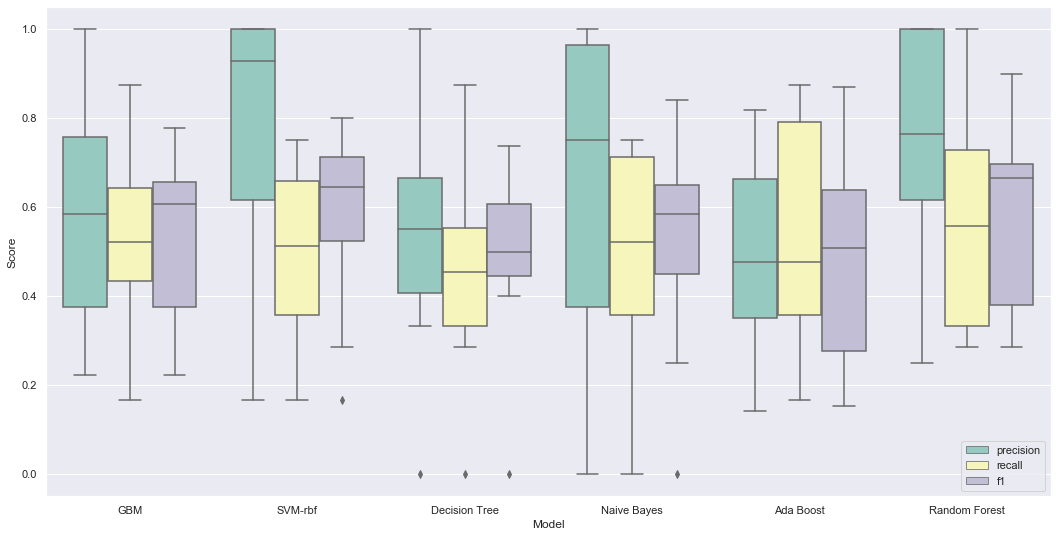

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
np.random.seed(10)

def N_fold_CV(X, y, N_cv = 10):

    models = []
    scores = []
    scoretype = []
    cv = KFold(n_splits= N_cv, random_state=1, shuffle=True)


    models = np.append(models, ['GBM']*3*N_cv) #Gradient Boost Machine
    model = GradientBoostingClassifier()
    scoretype = np.append(scoretype, ['precision']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['recall']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['f1']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1))

    models = np.append(models, ['SVM-rbf']*3*N_cv)
    model = SVC(kernel='rbf') # SVM-rbf
    scoretype = np.append(scoretype, ['precision']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['recall']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['f1']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1))

    models = np.append(models, ['Decision Tree']*3*N_cv)
    model = tree.DecisionTreeClassifier()
    scoretype = np.append(scoretype, ['precision']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['recall']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['f1']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1))

    models = np.append(models, ['Naive Bayes']*3*N_cv)
    model = GaussianNB()
    scoretype = np.append(scoretype, ['precision']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['recall']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['f1']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1))

    models = np.append(models, ['Ada Boost']*3*N_cv)
    model = AdaBoostClassifier()
    scoretype = np.append(scoretype, ['precision']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['recall']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['f1']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1))

    models = np.append(models, ['Random Forest']*3*N_cv)
    model = RandomForestClassifier()
    scoretype = np.append(scoretype, ['precision']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['recall']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1))
    scoretype = np.append(scoretype, ['f1']*N_cv)
    scores = np.append(scores, cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1))

    plt.ylabel('Score')
    plt.xlabel('Model')

    sns.set(style="whitegrid")
    sns.set(rc={'figure.figsize':(18,9)})
    ax = sns.boxplot(x=models, y=scores, hue=scoretype, palette="Set3")
    plt.show()
    
N_fold_CV(X, y, 10)

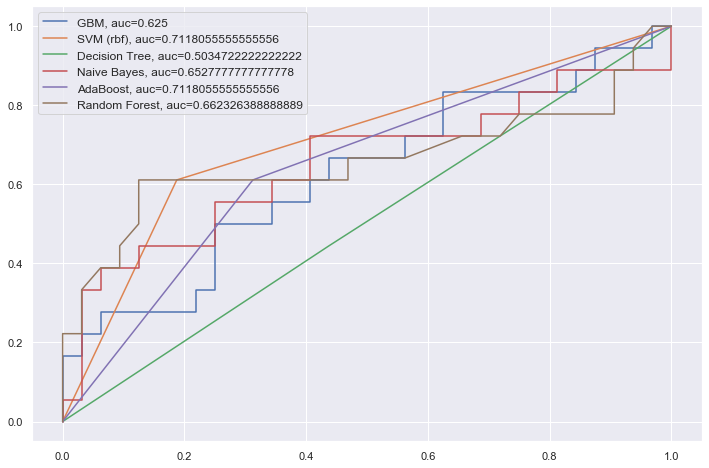

In [46]:
np.random.seed(10)
from sklearn import tree, metrics, model_selection, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

clf_baseline = GradientBoostingClassifier() # baseline GBM
clfDT = tree.DecisionTreeClassifier() # Decision Tree
gnb = GaussianNB() #Naive Bayes
ada = AdaBoostClassifier()
rdf = RandomForestClassifier()
clf_svm_2 = svm.SVC(kernel='rbf')

clf_baseline.fit(X_train,y_train)
clfDT.fit(X_train,y_train)
rdf.fit(X_train,y_train)
gnb.fit(X_train,y_train)
ada.fit(X_train,y_train)
clf_svm_2.fit(X_train,y_train)

plt.figure(figsize=(12,8))

fpr, tpr, thresh = metrics.roc_curve(y_test, clf_baseline.predict_proba(X_test)[:,1])
auc = metrics.roc_auc_score(y_test, clf_baseline.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label="GBM, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, clf_svm_2.predict(X_test))
auc = metrics.roc_auc_score(y_test, clf_svm_2.predict(X_test))
plt.plot(fpr,tpr,label="SVM (rbf), auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, clfDT.predict_proba(X_test)[:,1])
auc = metrics.roc_auc_score(y_test, clfDT.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label="Decision Tree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
auc = metrics.roc_auc_score(y_test, gnb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, ada.predict(X_test))
auc = metrics.roc_auc_score(y_test, clf_svm_2.predict(X_test))
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, rdf.predict_proba(X_test)[:,1])
auc = metrics.roc_auc_score(y_test, rdf.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))


plt.legend(loc=0, fontsize = 12)

### Grid-search (GBM)

In [13]:
from sklearn.model_selection import train_test_split
np.random.seed(10)

# Grid-search
from sklearn.model_selection import GridSearchCV

p_test = {'learning_rate':[0.05,0.01,0.005,0.001], 
          'n_estimators':[100,250,500,750,1000,1250],
          'max_depth':[2,3,4,5],
          'min_samples_split':[2,4,6,8,10,20],
          'min_samples_leaf':[1,3,5,7],
          'max_features':[2,3,4,5],
          'subsample':[0.8,0.85,0.9]}

tuning = GridSearchCV(estimator=GradientBoostingClassifier(random_state=10), 
            param_grid = p_test, scoring='f1',n_jobs=-1,verbose=2, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

Fitting 5 folds for each of 27648 candidates, totalling 138240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 634 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 1930 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 3874 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 5088 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 6466 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10658 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 11509 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 12440 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 13453 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 14546 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 19129 tasks

({'learning_rate': 0.05,
  'max_depth': 2,
  'max_features': 2,
  'min_samples_leaf': 7,
  'min_samples_split': 20,
  'n_estimators': 100,
  'subsample': 0.8},
 0.6373205741626794)

### Grid-search (Decision Tree)

In [14]:
from sklearn.model_selection import train_test_split
np.random.seed(10)

# Grid-search
from sklearn.model_selection import GridSearchCV

p_test = {'criterion':['gini', 'entropy'], 
          'max_depth':[2,3,4,5],
          'min_samples_split':[2,4,6,8,10,20],
          'min_samples_leaf':[1,3,5,7],
          'max_features':[2,3,4,5],
          'max_leaf_nodes':[None,2,4,6]}


tuning = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=10), 
            param_grid = p_test, scoring='f1',n_jobs=-1,verbose=2, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 11040 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 15360 out of 15360 | elapsed:    3.4s finished


({'criterion': 'entropy',
  'max_depth': 4,
  'max_features': 3,
  'max_leaf_nodes': None,
  'min_samples_leaf': 3,
  'min_samples_split': 10},
 0.6147230822153422)

### Grid-search (SVM)

In [15]:
from sklearn.model_selection import train_test_split
np.random.seed(10)

# Grid-search
from sklearn.model_selection import GridSearchCV

p_test = {'C':[1,5,10,20,50,100,120,150],
          'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
          'degree':[2,3,4,5],
          'gamma':['scale','auto'],
          'tol':[1e-3, 1e-4, 1e-5],
          'decision_function_shape':['ovo', 'ovr']}


tuning = GridSearchCV(estimator=SVC(random_state=10), 
            param_grid = p_test, scoring='f1',n_jobs=-1,verbose=2, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 7014 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 7649 out of 7680 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 7680 out of 7680 | elapsed:    2.8s finished


({'C': 20,
  'decision_function_shape': 'ovo',
  'degree': 2,
  'gamma': 'scale',
  'kernel': 'rbf',
  'tol': 0.001},
 0.6240472723310251)

### Grid-search (AdaBoostClassifier)

In [39]:
from sklearn.model_selection import train_test_split
np.random.seed(10)

# Grid-search
from sklearn.model_selection import GridSearchCV

p_test = {'n_estimators':[10,40,100,150,200,400, 600],
          'learning_rate':[1e-3, 1e-2, 1e-1, 1, 10, 20]}


tuning = GridSearchCV(estimator=AdaBoostClassifier(random_state=10), 
            param_grid = p_test, scoring='f1',n_jobs=-1,verbose=2, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 179 out of 210 | elapsed:    3.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    4.2s finished


({'learning_rate': 1, 'n_estimators': 400}, 0.5929813664596273)

### Grid-search (RandomForestClassifier)

In [17]:
from sklearn.model_selection import train_test_split
np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Grid-search
from sklearn.model_selection import GridSearchCV

p_test = {'n_estimators':[10,20,50,100,150,200],
          'criterion': ['gini', 'entropy'],
          'max_depth':[None,2,3,4,5],
          'min_samples_split':[2,4,6,8],
          'min_samples_leaf':[1,3,5,7],
          'max_features':['auto', 'sqrt', 'log2'],
          'max_leaf_nodes':[None,2,4,6]}


tuning = GridSearchCV(estimator=RandomForestClassifier(), 
            param_grid = p_test, scoring='f1',n_jobs=-1,verbose=2, cv=5)
tuning.fit(X_train,y_train)
tuning.best_params_, tuning.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 11520 candidates, totalling 57600 fits


[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1172 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 3764 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 5544 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 7652 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 10080 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 12836 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 15912 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 19316 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 23040 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 27092 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 31464 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 36164 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 41184 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 46532 tasks      | 

({'criterion': 'entropy',
  'max_depth': 2,
  'max_features': 'auto',
  'max_leaf_nodes': 6,
  'min_samples_leaf': 3,
  'min_samples_split': 4,
  'n_estimators': 20},
 0.6789915966386555)

## Optimized

In [42]:
def get_F1_avg_optimized(X_train, X_test, y_train, y_test):
    np.random.seed(10)
    models = []
    precision = []
    recall = []
    f_1 = []
    accuracy = []

    models.append('GBM-Grid Search')
    # baseline model
    model = GradientBoostingClassifier(learning_rate= 0.05,
                                      max_depth= 2,
                                      max_features= 2,
                                      min_samples_leaf= 7,
                                      min_samples_split= 20,
                                      n_estimators= 100,
                                      subsample= 0.8)
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('SVM-rbf-Grid Search')
    model = SVC(C= 20,
                decision_function_shape= 'ovo',
                degree= 2,
                gamma= 'scale',
                kernel= 'rbf',
                tol= 0.001) # SVM-rbf
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('Decision Tree-Grid Search')
    model = tree.DecisionTreeClassifier(criterion= 'entropy',
                                      max_depth= 4,
                                      max_features= 3,
                                      max_leaf_nodes= None,
                                      min_samples_leaf= 3,
                                      min_samples_split= 10)
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('Naive Bayes')
    model = GaussianNB()
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))


    models.append('Ada Boost-Grid Search')
    model = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1),
                             algorithm="SAMME", learning_rate = 1,
                             n_estimators=200)
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    models.append('Random Forest-Grid Search')
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    precision.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[0])
    recall .append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[1])
    f_1.append(precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted')[2])
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

    return pd.DataFrame({'Model': models, 'Precision': precision, 'Recall':recall, 'F1':f_1})

    
get_F1_avg_optimized(X_train, X_test, y_train, y_test)

,Model,Precision,Recall,F1
0,GBM-Grid Search,0.737184,0.74,0.738286
1,SVM-rbf-Grid Search,0.754921,0.76,0.752059
2,Decision Tree-Grid Search,0.620779,0.60,0.606667
3,Naive Bayes,0.631765,0.64,0.634866
4,Ada Boost-Grid Search,0.728000,0.72,0.722852
5,Random Forest-Grid Search,0.776000,0.78,0.774925


In [23]:
np.random.seed(10)
get_F1_avg(X_train, X_test, y_train, y_test)

,Model,Precision,Recall,F1
0,GBM,0.620779,0.60,0.606667
1,SVM-rbf,0.737184,0.74,0.738286
2,Decision Tree,0.585127,0.58,0.582342
3,Naive Bayes,0.631765,0.64,0.634866
4,Ada Boost,0.674089,0.66,0.664716
5,Random Forest,0.755735,0.76,0.756578


## Step 4 (Clustering)

In [14]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

silouettes = []
purity=[]


for K in range(2,6):
    kmeans = KMeans(n_clusters=K, random_state=2).fit(X)
    result_labels = kmeans.labels_
    silouettes.append(silhouette_score(X, result_labels))
    purity.append(purity_score(y, result_labels))
    
purity

[0.5843373493975904,
 0.5843373493975904,
 0.6445783132530121,
 0.6807228915662651]

In [18]:
np.random.seed(10)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_mutual_info_score
    

centers = []
    
K = 2
kmeans = KMeans(n_clusters=K, random_state=2).fit(X)
result_labels = kmeans.labels_
print('Center of clusters:')
print(list(df_ml_pa)[1:5])
print(kmeans.cluster_centers_)
centers.append(kmeans.cluster_centers_)
print('-----------------------------------------------------------------------')
num = []
for i in range(K):
    print('Label:', i, round(list(result_labels).count(i)/len(result_labels)*100,2), '%')
    print('Label:', i, list(result_labels).count(i))
    num.append(list(result_labels).count(i))

bool_arr1 = result_labels == 0
bool_arr2 = result_labels == 1
indexCluster0 = np.where(bool_arr1)[0]
indexCluster1 = np.where(bool_arr2)[0]

Center of clusters:
['Location_slope', 'Scale_intercept', 'Location_intercept', 'Scale_slope']
[[ 0.36267573 -0.61595666  1.40797672 -0.48154059]
 [-0.27212773  0.50441552  0.3302478   0.38974574]]
-----------------------------------------------------------------------
Label: 0 45.78 %
Label: 0 76
Label: 1 54.22 %
Label: 1 90


In [19]:
# since label 0 is the maintainer's group
K_means_labels = 1 - kmeans.labels_

In [20]:
K_means_labels.shape

(166,)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y, result_labels)

array([[48, 49],
       [28, 41]], dtype=int64)

In [42]:
# DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#X = StandardScaler().fit(X)
db = DBSCAN(eps=0.5, min_samples=6).fit(X)
labels_db = db.labels_


In [64]:
sum(labels_db==-1) /len(labels_db)

0.8192771084337349

In [56]:
#['Location_slope', 'Scale_intercept', 'Location_intercept', 'Scale_slope']
index_0 = [i for i, j in enumerate(labels_db) if j == 3]
np.mean(X[index_0], axis = 0)

array([-0.32280053,  0.43875521, -0.0548674 ,  0.024205  ])

### Cluster Evaluation Metrics

In [58]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import fowlkes_mallows_score

def evaluate_cluster(labels_true, labels_pred):
    RIS = adjusted_rand_score(labels_true, labels_pred)
    SS = silhouette_score(labels_true.reshape(-1, 1), labels_pred, metric = 'euclidean')
    NMIS = normalized_mutual_info_score(labels_true, labels_pred)
    AMIS = adjusted_mutual_info_score(labels_true, labels_pred)
    FMS = fowlkes_mallows_score(labels_true, labels_pred)
    return([RIS, SS, NMIS, AMIS, FMS])

In [82]:
evaluate_cluster(y, result_labels)

[0.008541415426606233,
 0.01620427231507615,
 0.0060478319231969955,
 0.0023605631952012818,
 0.5194445136225486]

In [52]:
evaluation = []
#definiton 1 MVPA - SED
evaluation.append(evaluate_cluster(y, result_labels))

In [95]:
df_results = pd.DataFrame(evaluation, columns =['Adjusted Rand Index', 'Silhouette Coefficient','Normalized MIS', 'Adjusted MIS', 'Fowlkes-Mallows Score'])
df_results.insert(loc=0, column='Outcome', value=['MVPA','SED','MVPA','SED'])
df_results.insert(loc=1, column='Definition', value=[1, 1, 2, 2])
df_results

,Outcome,Definition,Adjusted Rand Index,Silhouette Coefficient,Normalized MIS,Adjusted MIS,Fowlkes-Mallows Score
0,MVPA,1,-0.000828,-0.000424,0.005688,0.001249,0.505477
1,SED,1,-0.006839,-0.012118,0.008928,0.004438,0.530550
2,MVPA,2,-0.004942,-0.010443,0.000006,-0.003773,0.511722
3,SED,2,0.008541,0.016204,0.006048,0.002361,0.519445


## Step 5 (Add additional time-based features)

In [51]:
df_pa_location = df_pa_location[df_pa_location['ID'].isin(list(df_ml_pa['ID']))]
df_cluster = df_ml_pa
df_cluster['cluster_label'] = result_labels
df_pa_location['cluster_label'] = result_labels
df_cluster.head(5)

,ID,Location_slope,Scale_intercept,Location_intercept,Scale_slope,Label,cluster_label
0,6,2.301439,1.046337,3.1160,1.035000,Non-Maintainer,0
1,7,-0.484107,0.082989,1.6330,0.500500,Non-Maintainer,1
2,12,-0.406901,-1.413269,1.9250,-0.058720,Non-Maintainer,0
3,14,1.503791,-0.155468,0.8163,-0.003361,Non-Maintainer,0
4,15,-0.089806,-0.816965,1.1010,-0.963300,Non-Maintainer,0


In [52]:
# Final range of values (follow-up)
def get_follow_up(df):  
    df['follow_up'] = (df['FU6'] + df['FU7'] + df['FU8'])/3
    
    df = df.drop(df[df['follow_up'] == 0].index)
    
    return df

df_temp = get_follow_up(df_pa_location)

location_final = np.mean(list(df_pa_location[df_pa_location['cluster_label']==0]['follow_up']))
scale_final = np.std(list(df_pa_location[df_pa_location['cluster_label']==0]['follow_up']))

In [53]:
IDs = []
T_Reach = [] #time to reach location
L_IR = [] #location time in range
L_OR = [] #location time out range
S_IR = [] #scale time in range
S_OR = [] #scale time out range

for each in df_pa_location.values.tolist():
    IDs.append(each[0])
    reach = False
    Time_Reach = 1
    L_in_time = 0
    L_out_time = 0
    S_in_time = 0
    S_out_time = 0
    
    for i in range(1,12):
        if(each[i] != 0): #not missing value
            
            #Time to to reach
            if(reach == False and each[i] > location_final):
                T_Reach.append(Time_Reach)
                reach = True
            else:
                Time_Reach = Time_Reach + 1
    
            #location in and out
            if(each[i] >= location_final):
                L_in_time = L_in_time + 1
            else:
                L_out_time = L_out_time + 1
            
            #scale in and out
            if(each[i] >= scale_final):
                S_in_time = S_in_time + 1
            else:
                S_out_time = S_out_time + 1
    
    #location/scale
    L_IR.append(L_in_time)
    L_OR.append(L_out_time)
    S_IR.append(S_in_time)
    S_OR.append(S_out_time)
    
    #never reach
    if (reach == False):
        T_Reach.append(Time_Reach)
        
df_additional =  pd.DataFrame({'ID': IDs, 'TTR': T_Reach, 'LocationTIR':L_IR, 'LocationTOR':L_OR, 'ScaleTIR':S_IR, 'ScaleTOR': S_OR})      

In [54]:
df_additional.head(5)

,ID,TTR,LocationTIR,LocationTOR,ScaleTIR,ScaleTOR
0,6,1,11,0,11,0
1,7,1,7,4,7,4
2,12,1,9,1,9,1
3,14,3,7,4,7,4
4,15,2,3,8,4,7


### Machine Learning with Additional Features

In [55]:
df_ml_2 = pd.merge(df_ml_pa, df_additional, on=['ID'], how = 'inner')
df_ml_2.head(5)

,ID,Location_slope,Scale_intercept,Location_intercept,Scale_slope,Label,cluster_label,TTR,LocationTIR,LocationTOR,ScaleTIR,ScaleTOR
0,6,2.301439,1.046337,3.1160,1.035000,Non-Maintainer,0,1,11,0,11,0
1,7,-0.484107,0.082989,1.6330,0.500500,Non-Maintainer,1,1,7,4,7,4
2,12,-0.406901,-1.413269,1.9250,-0.058720,Non-Maintainer,0,1,9,1,9,1
3,14,1.503791,-0.155468,0.8163,-0.003361,Non-Maintainer,0,3,7,4,7,4
4,15,-0.089806,-0.816965,1.1010,-0.963300,Non-Maintainer,0,2,3,8,4,7


In [56]:
def getX_y2(df):

    X = df[['Location_slope', 'Scale_intercept', 'Location_intercept', 'Scale_slope', 'TTR','LocationTIR','LocationTOR','ScaleTIR', 'ScaleTOR']]
    X = np.asarray(X)
    labels = []
    for item in df['Label']:
        if item == 'Maintainer':
            labels.append(1)
        else:
            labels.append(0)
    y = np.asarray(labels)

    return(X, y)

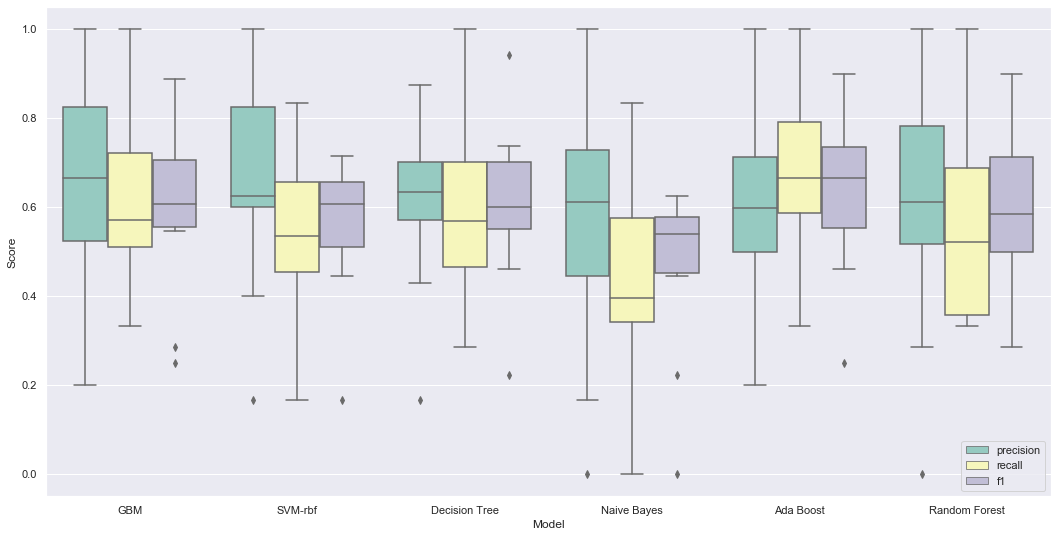

In [57]:
np.random.seed(10)
X, y = getX_y2(df_ml_2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

N_fold_CV(X, y, N_cv = 10)

In [58]:
np.random.seed(10)
get_F1_avg(X_train, X_test, y_train, y_test)

,Model,Precision,Recall,F1
0,GBM,0.783090,0.78,0.781227
1,SVM-rbf,0.733714,0.74,0.734003
2,Decision Tree,0.567536,0.54,0.548557
3,Naive Bayes,0.696613,0.70,0.698022
4,Ada Boost,0.737184,0.74,0.738286
5,Random Forest,0.733714,0.74,0.734003


In [60]:
X_train

array([[ 0.1261347 ,  0.2569681 ,  1.301     , ...,  1.        ,
        10.        ,  1.        ],
       [ 1.14998999,  0.23534452,  1.881     , ...,  4.        ,
         6.        ,  4.        ],
       [-1.08246574,  1.0370267 ,  0.06943   , ...,  8.        ,
         2.        ,  6.        ],
       ...,
       [-0.35206898, -1.87840663,  1.872     , ...,  7.        ,
         4.        ,  7.        ],
       [-0.38839264, -0.34808846,  0.8309    , ...,  9.        ,
         1.        ,  9.        ],
       [ 0.13873281, -0.87532653,  1.873     , ...,  2.        ,
         9.        ,  2.        ]])